In [1]:
import numpy as np
import time
from copy import deepcopy

import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise
from qiskit.visualization import iplot_state_city

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


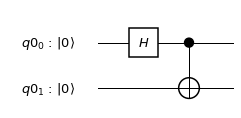

In [2]:
# Create the expected density matrix
q2 = QuantumRegister(2)
qc = QuantumCircuit(q2)
qc.h(q2[0])
qc.cx(q2[0], q2[1])

job = qiskit.execute(qc, Aer.get_backend('statevector_simulator'))
state = job.result().get_statevector(qc)
print(state)
qc.draw(output='mpl')

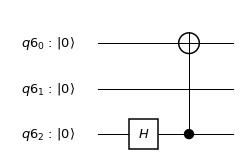

In [20]:
# Create the actual circuit 
q2 = QuantumRegister(3)
qc = QuantumCircuit(q2)
qc.h(q2[2])
qc.cx(q2[2], q2[0])
qc.draw(output='mpl')

In [21]:
# Generate circuits and run on simulator
t = time.time()
# Generate the state tomography circuits. Only pass in the 
# registers we want to measure (in this case 3 and 5)
qst_qc = state_tomography_circuits(qc, [q2[0],q2[2]])
job = qiskit.execute(qst_qc, Aer.get_backend('qasm_simulator'), shots=5000)
print('Time taken:', time.time() - t)

tomo_qc = StateTomographyFitter(job.result(), qst_qc)

Time taken: 0.15263080596923828


In [22]:
# Perform the tomography fit
# which outputs a density matrix
rho_qc = tomo_qc.fit()
fid_qc = state_fidelity(state, rho_qc)
print('Fit Fidelity =', fid_qc)

Fit Fidelity = 0.9958040175047234


In [6]:
#Add measurement noise for an imperfect model
noise_model = noise.NoiseModel()
for qi in range(6):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1,0.9]])
    noise_model.add_readout_error(read_err,[qi])
    
#generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[3,5])

backend = Aer.get_backend('qasm_simulator')
job_cal = qiskit.execute(meas_calibs, backend=backend, shots=15000, noise_model=noise_model)
job_tomo = qiskit.execute(qst_qc, backend=backend, shots=15000, noise_model=noise_model)

meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

tomo_qc = StateTomographyFitter(job_tomo.result(), qst_qc)

#no correction
rho_qc = tomo_qc.fit()
fid_qc = state_fidelity(state, rho_qc)
print('Fit Fidelity (no correction) =', fid_qc)

#correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
tomo_qc = StateTomographyFitter(correct_tomo_results, qst_qc)
rho_qc = tomo_qc.fit()
fid_qc = state_fidelity(state, rho_qc)
print('Fit Fidelity (w/ correction) =', fid_qc)

Fit Fidelity (no correction) = 0.5736997665586768
Fit Fidelity (w/ correction) = 0.9840063826289982


In [7]:
# Create a state preparation circuit
q5 = QuantumRegister(5)
bell5 = QuantumCircuit(q5)
bell5.h(q5[0])
for j in range(4):
    bell5.cx(q5[j], q5[j + 1])

# Get ideal output state
job = qiskit.execute(bell5, Aer.get_backend('statevector_simulator'))
psi_bell5 = job.result().get_statevector(bell5)

# Generate circuits and run on simulator
t = time.time()
qst_bell5 = state_tomography_circuits(bell5, q5)
job = qiskit.execute(qst_bell5, Aer.get_backend('qasm_simulator'), shots=5000)

# Extract tomography data so that counts are indexed by measurement configuration
tomo_bell5 = StateTomographyFitter(job.result(), qst_bell5)
print('Time taken:', time.time() - t)

Time taken: 6.127607822418213


In [8]:
t = time.time()
rho_lstsq_bell5 = tomo_bell5.fit(method='lstsq')
print('Least-Sq Reconstruction')
print('Time taken:', time.time() - t)
print('Fit Fidelity:', state_fidelity(psi_bell5, rho_lstsq_bell5))

Least-Sq Reconstruction
Time taken: 4.302490472793579
Fit Fidelity: 0.9936243237087656


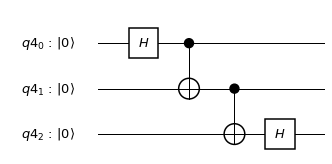

In [9]:
# Create the actual circuit 
q2 = QuantumRegister(3)
ghz = QuantumCircuit(q2)
ghz.h(q2[0])
ghz.cx(q2[0], q2[1])
ghz.cx(q2[1], q2[2])
ghz.h(q2[2])
ghz.draw(output='mpl')

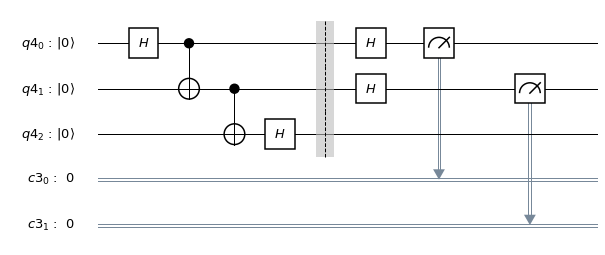

In [10]:
qst_ghz = state_tomography_circuits(ghz, [q2[0],q2[1]])
qst_ghz[0].draw(output='mpl')

In [11]:
#Make a copy without the ancilla register
qst_ghz_no_anc = deepcopy(qst_ghz)
ca = ClassicalRegister(1)
for qst_ghz_circ in qst_ghz:
    qst_ghz_circ.add_register(ca)
    qst_ghz_circ.measure(q2[2],ca[0])

In [12]:
#Run in Aer
job = qiskit.execute(qst_ghz, Aer.get_backend('qasm_simulator'), shots=10000)
raw_results = job.result()

In [13]:
new_result = deepcopy(raw_results)

for resultidx, _ in enumerate(raw_results.results):
    old_counts = raw_results.get_counts(resultidx)
    new_counts = {}
    
    #change the size of the classical register
    new_result.results[resultidx].header.creg_sizes = [new_result.results[resultidx].header.creg_sizes[0]]
    new_result.results[resultidx].header.clbit_labels = new_result.results[resultidx].header.clbit_labels[0:-1]
    new_result.results[resultidx].header.memory_slots = 2
    
    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        if reg_bits[0]=='1':
            new_counts[reg_bits[1]]=old_counts[reg_key]

    new_result.results[resultidx].data.counts = \
        new_result.results[resultidx]. \
        data.counts.from_dict(new_counts)

In [14]:
tomo_bell = StateTomographyFitter(new_result, qst_ghz_no_anc)
# Perform the tomography fit
# which outputs a density matrix
rho_bell = tomo_bell.fit()

In [15]:
np.around(rho_bell,3)

array([[ 0.505+0.j   ,  0.005-0.003j, -0.   -0.j   , -0.497-0.001j],
       [ 0.005+0.003j,  0.001+0.j   ,  0.001-0.001j, -0.005-0.001j],
       [-0.   +0.j   ,  0.001+0.001j,  0.001+0.j   , -0.   +0.002j],
       [-0.497+0.001j, -0.005+0.001j, -0.   -0.002j,  0.493+0.j   ]])

In [16]:
iplot_state_city(np.around(rho_bell,3))